In [1]:
from skimage import io
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image

import cv2



# functions

### parameters

In [94]:
## parameters

shape_patches=np.array((15,15))
kappa=1
t0=0.15

## type = int np.uint8 ou float np.float64 en fonction de ce qui est nécessaire

### Miminum over each color channel

In [4]:
def min_canal(I,type):
    n,p = I.shape[0:2]
    im_res = np.zeros((n,p),dtype = type)
    
    for i in range(n):
        for j in range(p):
            if(type==np.uint8):
                im_res[i][j] = int(min(I[i][j]))
            else:
                im_res[i][j] = min(I[i][j])
            
    
    return(im_res)

### Minimum over patch pixel

In [5]:
#fonction minimum par patch de taille 15*15


def min_Patch_v2(patches,min_canal,shape_patches,type):
    (n,p) = min_canal.shape[0:2]
    l=shape_patches[0]
    h = n-(l//2)*2
    w = p-(l//2)*2
    number_patches=np.shape(patches)[0]
    im_res = np.zeros((n,p),dtype = type)
    for i in range(number_patches):
        (q,r)=(i//w,i%w)
        im_res[q+l//2,r+l//2]=np.amin(patches[i])
        
## first border part
    a=((l//2))
    for i in range(a):
        for j in range(p):
            mini = min_canal[i,j]
            for k in range (max(i-a,0),min(i+a,n)):
                for l in range (max(j-a,0),min(j+a,p)):
                    if min_canal[k,l]<mini :
                        mini = min_canal[k,l]
            im_res[i,j] = mini

## Second border part           
    for i in range(n):
        for j in range(a):
            mini = min_canal[i,j]
            for k in range (max(i-a,0),min(i+a,n)):
                for l in range (max(j-a,0),min(j+a,p)):
                    if min_canal[k,l]<mini :
                        mini = min_canal[k,l]
            im_res[i,j] = mini

## Third border part           
    for i in range(n-a-1,n):
        for j in range(p):
            mini = min_canal[i,j]
            for k in range (max(i-a,0),min(i+a,n)):
                for l in range (max(j-a,0),min(j+a,p)):
                    if min_canal[k,l]<mini :
                        mini = min_canal[k,l]
            im_res[i,j] = mini
## Fourth border part
    for i in range(n):
        for j in range(p-a-1,p):
            mini = min_canal[i,j]
            for k in range (max(i-a,0),min(i+a,n)):
                for l in range (max(j-a,0),min(j+a,p)):
                    if min_canal[k,l]<mini :
                        mini = min_canal[k,l]
            im_res[i,j] = mini


    return(im_res)

### dark channel function

In [6]:
## definition de la fonction dark_channel
def dark_channel(I,shape_patches,type):
    min_canal_image= min_canal(I,type)
    patches = image.extract_patches_2d(min_canal_image,shape_patches)
    return(min_Patch_v2(patches,min_canal_image,shape_patches,type))

### computing athmospheric light

In [7]:
def At_light_part1_v2(patches,I,min_canal,shape_patches):
    n,p = I.shape[0:2]
    I_dark = min_Patch_v2(patches,min_canal,shape_patches,np.uint8)
    res = []
    for i in range(n):
        for j in range(p):
            res.append((I_dark[i,j],i,j))
            
    res=np.asarray(res)
    length=np.shape(res)[0]
    res.view('i8,i8,i8').sort(order=['f0'], axis=0) 
    res_thresh = res[int(0.999*length):length,:]
    
    return (res_thresh)

def At_light_part2(At_light_part1,I):
    imageR = I[:,:,0]
    imageG = I[:,:,1]
    imageB = I[:,:,2]
    
    At_light_R=[]
    At_light_G=[]
    At_light_B=[]
    
    index=[]
    
    length = np.shape(At_light_part1)[0]
    
    p=int(0.01*length)
    
    for i in range(length):
        index.append(At_light_part1[i][1:3])
    
    for i in range(length):
        (n,p) = (index[i][0],index[i][1])
        At_light_R.append(imageR[n,p])
        At_light_G.append(imageG[n,p])
        At_light_B.append(imageB[n,p])
    
    At_light_R=np.sort(At_light_R)
    At_light_G=np.sort(At_light_G)
    At_light_B=np.sort(At_light_B)
    
    At_light_R=At_light_R[int(0.99*length):]
    At_light_G=At_light_G[int(0.99*length):]
    At_light_B=At_light_B[int(0.99*length):]
    
    At_light_R=int(np.mean(At_light_R))
    At_light_G=int(np.mean(At_light_G))
    At_light_B=int(np.mean(At_light_B))



    return(At_light_R,At_light_G,At_light_B)

### Transmission

In [95]:
def transmission2(I,At_light_R,At_light_G,At_light_B,shape_patches):
    I_grey = cv2.cvtColor( I, cv2.COLOR_RGB2GRAY )
    plt.imshow(I_grey)
    plt.show()
    I_normalised = np.zeros((I.shape),dtype = np.float64)
    I_normalised[:,:,0]= (I[:,:,0]/float(At_light_R))
    I_normalised[:,:,1]= (I[:,:,1]/float(At_light_G))
    I_normalised[:,:,2]= (I[:,:,2]/float(At_light_B))
    
    I_ac_dark = dark_channel(I_normalised,shape_patches,np.float64)
    darkchannel = guidedfilter0(I_ac_dark,I_grey,1,0.0001)
    
    

    t = np.ones((I.shape[0:2]),dtype = np.float64)
    t1 = (t- I_ac_dark)
    t = (t- darkchannel)
    #t =I_grey
    t = np.ones((I.shape[0:2]),dtype = np.float64)-kappa*(np.ones((I.shape[0:2]))-t)### reajustement avec kappa = 0,95
    return(t,t1)

### Image without haze

In [96]:
def J_image(I,At_light_R,At_light_G,At_light_B,t,t0):
    n,p = I.shape[0:2]
    Jres =np.ones((n,p,3),dtype = np.uint8)
    for i in range(n):
        for j in range(p):
            Jres[i,j,0]= ((I[i,j,0]- At_light_R)/float(max(t[i,j],t0)) )+ At_light_R
            Jres[i,j,1]= ((I[i,j,1]- At_light_G)/float(max(t[i,j],t0)) )+ At_light_G
            Jres[i,j,2]= ((I[i,j,2]- At_light_B)/float(max(t[i,j],t0)) )+ At_light_B
    return(Jres)

### Dehazing function

In [112]:
def dehaze(I,shape_patches):

    min_canal_image= min_canal(I,np.uint8)
    
    patches = image.extract_patches_2d(min_canal_image,shape_patches)
    
    At_light_part1=At_light_part1_v2(patches,imageP,min_canal_image,shape_patches)
    
    (At_light_R,At_light_G,At_light_B) =At_light_part2(At_light_part1,imageP)    
    
    (t,t1) = transmission2(imageP,At_light_R,At_light_G,At_light_B,shape_patches)
    
    print(np.max(t1))
    plt.figure(figsize = (15,15))
    plt.imshow(t,'gray')
    plt.show()
    
    plt.imshow(t1,'gray')
    plt.show()
    
    J = J_image(imageP,At_light_R,At_light_G,At_light_B,t,t0)
    print(J)
    
    return (J)

### Guided filter function

In [103]:
def guidedfilter0(im1,im2,r,epsilon): # pour les images en niveau de gris

    n,p  = im2.shape

    im1 = im1/255 #Les pixels peuvent prendre des valeurs entre 0 et 1
    im2 = im2/255

    ksize = (2*r+1, 2*r+1)
    kernel = np.ones(ksize) # Noyau de convolution, représente le patch de taille 2*r+1
    
    W = cv2.filter2D(np.ones((n,p)), -1, kernel, borderType = cv2.BORDER_ISOLATED) # Pour normaliser les moyennes tout en prenant en compte les bords

    mean_1 = cv2.filter2D(im1, -1,kernel, borderType = cv2.BORDER_ISOLATED) / W #on calcule les moyennes de chaque patch
    
    mean_2 = cv2.filter2D(im2, -1,kernel, borderType = cv2.BORDER_ISOLATED) / W #moyennes par patch pour l'image 2(en niveau de gris)

    mean_12 = cv2.filter2D(im1*im2, -1,kernel, borderType = cv2.BORDER_ISOLATED) / W #on calcule les moyennes par patch du produit de l'image 1 avec la deuxième 


    cov_12 = mean_12 - mean_1 * mean_2 #la covariance de l'image 1 et l'image2


    var_1 = cv2.filter2D(im1*im1, -1,kernel, borderType = cv2.BORDER_ISOLATED) / W - mean_1 * mean_1 # variance de chaque patch de l'image 1

    a = cov_12/(np.ones((n,p))+var_1) #equation (3) de l'article
    
    b = mean_2 - a*mean_1 # Equation (4) de l'article

    o = (cv2.filter2D(a, -1, kernel, borderType = cv2.BORDER_ISOLATED)* im1
        + cv2.filter2D(b, -1, kernel, borderType = cv2.BORDER_ISOLATED))/W  # Equation (9) de l'article
    return(o)


# Test

In [113]:
## IMAGE
## Just change imagename

path = "Dataset/"
imagename = "trees"
extension = ".jpg"

filename = path+imagename+extension

imageP = io.imread(filename)


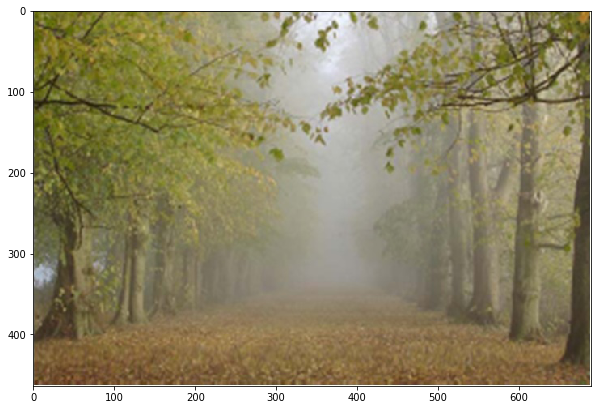

In [114]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(imageP)
plt.show()

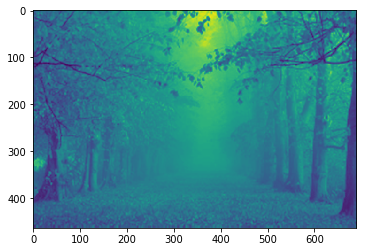

1.0


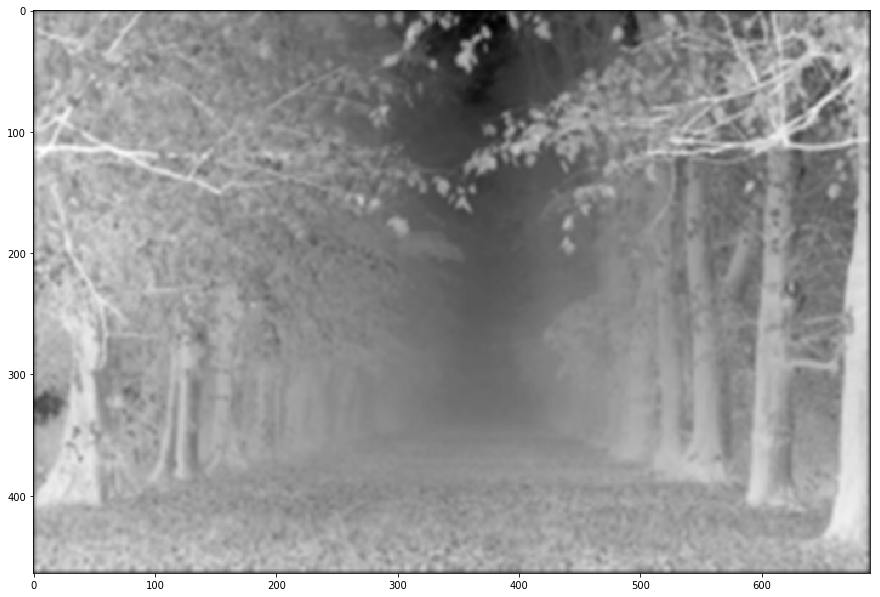

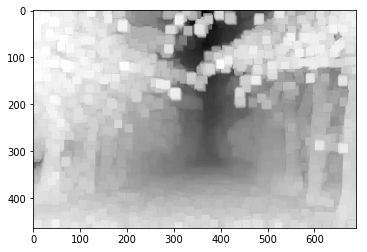

[[[ 10 240 255]
  [  7 251 223]
  [  5 255 174]
  ..., 
  [  6 255  92]
  [  9 255  89]
  [ 12 255 120]]

 [[  7 255 207]
  [ 56  52 210]
  [138 144  14]
  ..., 
  [196 115 199]
  [ 84  44 159]
  [  9 255 139]]

 [[  5 255 155]
  [127 127 255]
  [204 213  60]
  ..., 
  [ 19 192   5]
  [152 120   3]
  [  7 255 162]]

 ..., 
 [[  4 241 222]
  [162 111  87]
  [240 185 151]
  ..., 
  [251 186  98]
  [168 124  69]
  [  5 248 203]]

 [[  6 251 241]
  [ 75  44  20]
  [157 113  82]
  ..., 
  [182 110  41]
  [ 78  24 214]
  [  7 247 192]]

 [[247 255 255]
  [  5 245 228]
  [  3 249 218]
  ..., 
  [  5 236 192]
  [  7 243 162]
  [ 10 245 178]]]


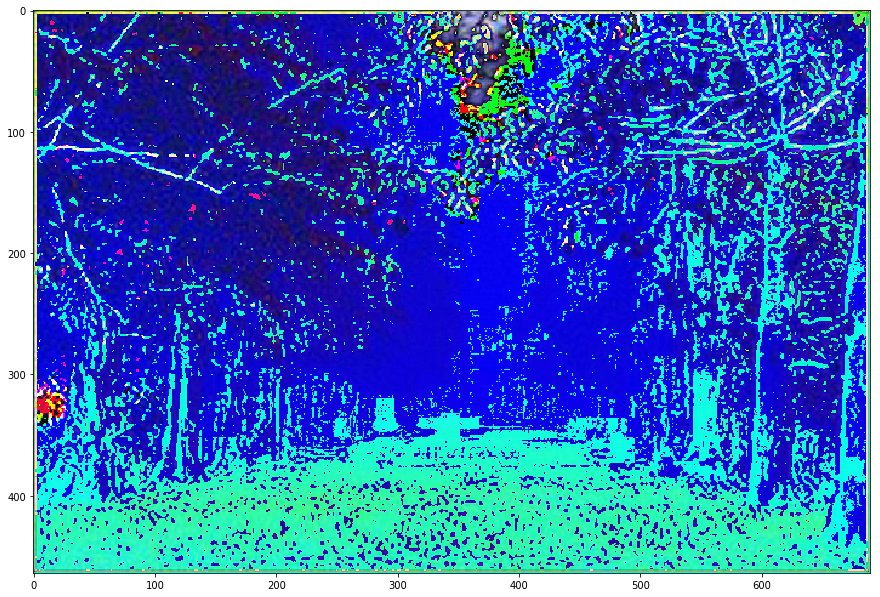

In [115]:
J = dehaze(imageP,(15,15))
plt.figure(figsize=(15,15))
plt.imshow(J,'gray')
plt.show()

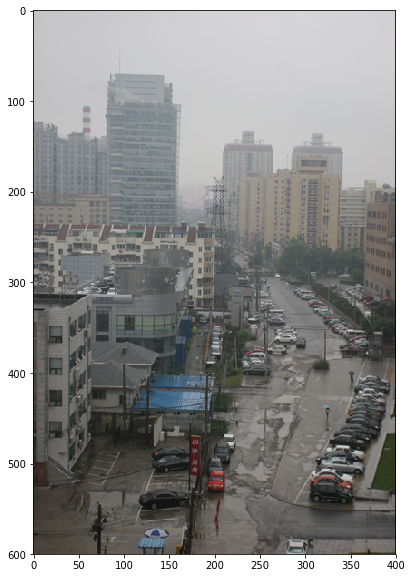

In [85]:
plt.figure(figsize=(10,10))   
plt.imshow(imageP)
plt.show()

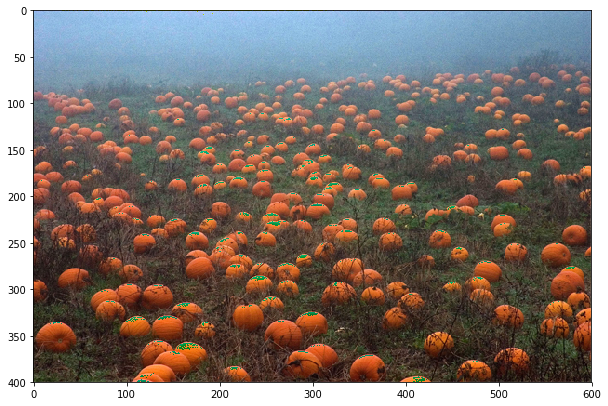

In [255]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(Jc)
plt.show()

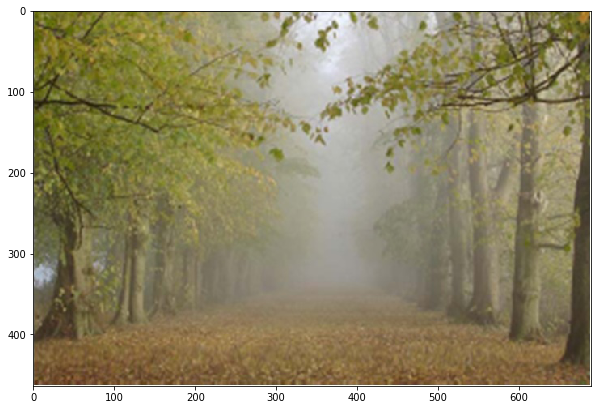

In [154]:
plt.figure(figsize=(10,10))   
plt.imshow(imageP)
plt.show()

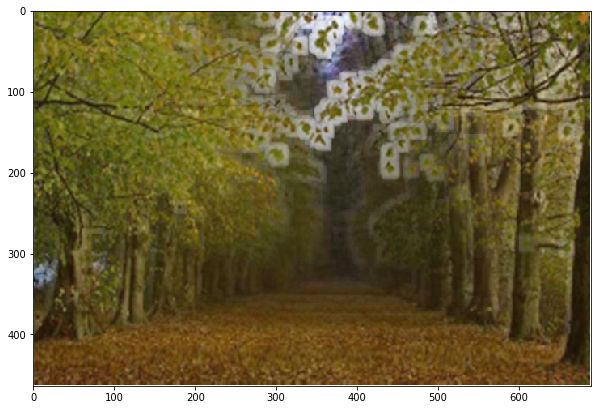

In [156]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(Jc)
plt.show()

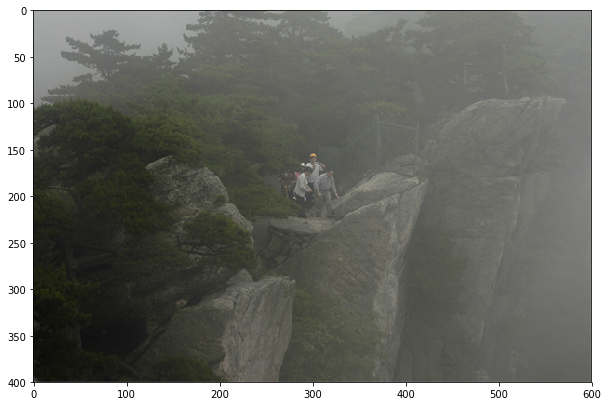

In [178]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(imageP)
plt.show()

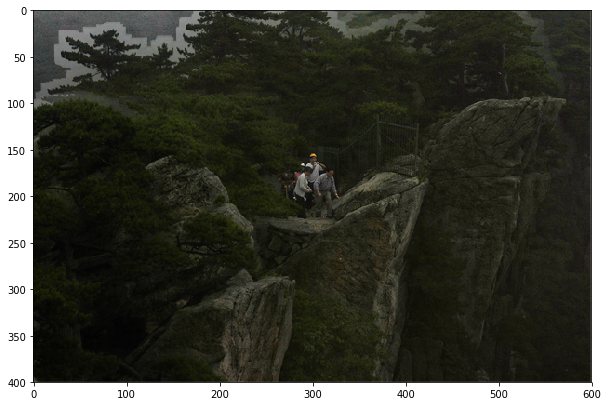

In [179]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(Jc)
plt.show()

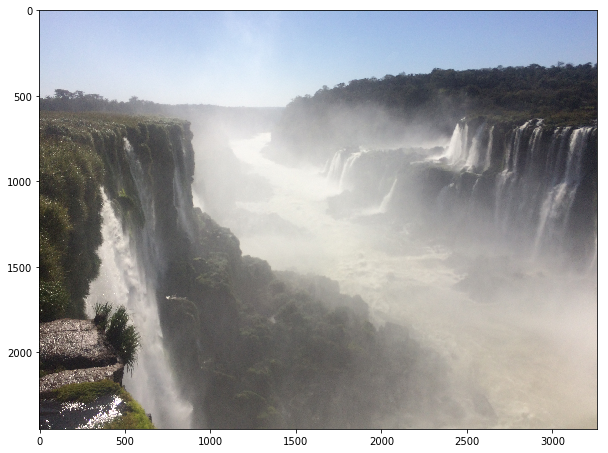

In [186]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(imageP)
plt.show()

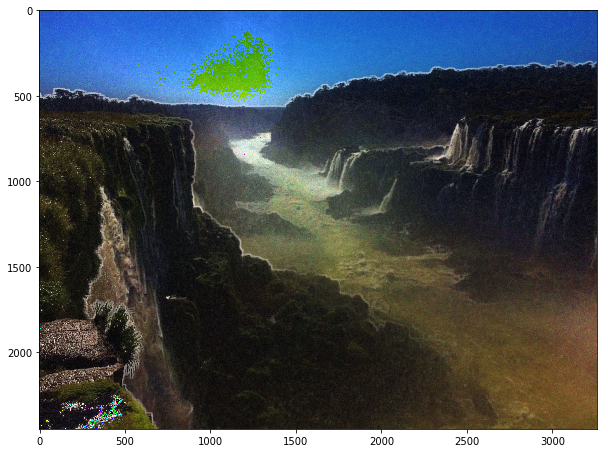

In [187]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(Jc)
plt.show()

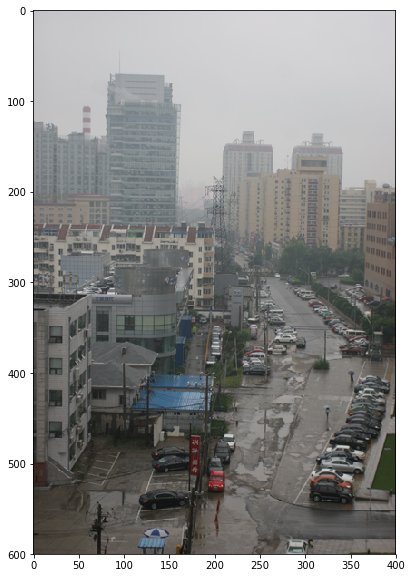

In [190]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(imageP)
plt.show()

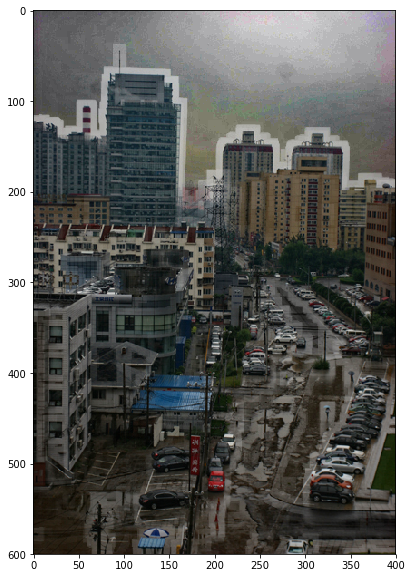

In [192]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(Jc)
plt.show()

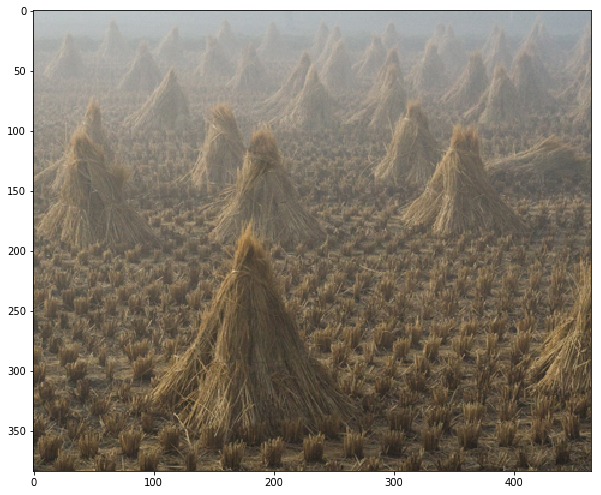

In [196]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(imageP)
plt.show()

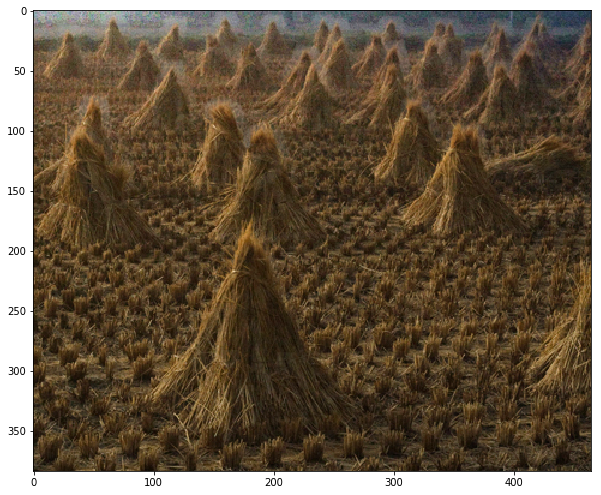

In [197]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(Jc)
plt.show()

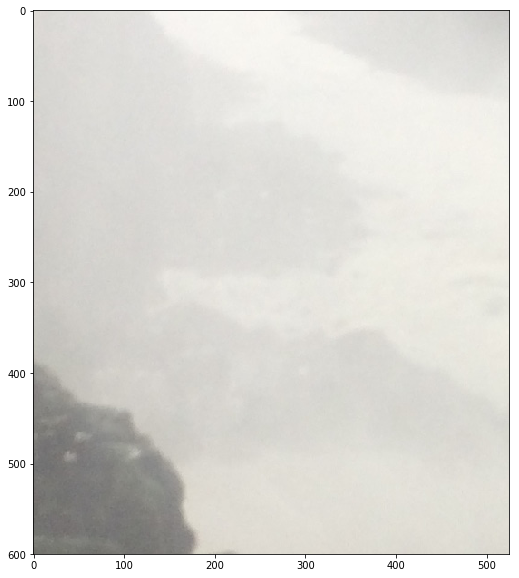

In [206]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(imageP)
plt.show()

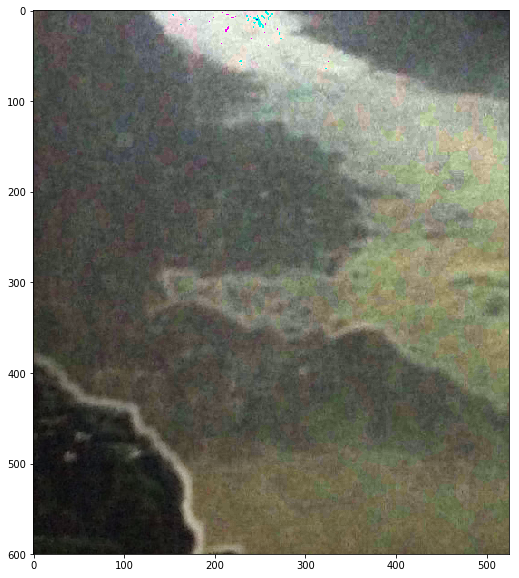

In [208]:
plt.figure(figsize=(10,10))     ##permet d'afficher l'image en plus grand
plt.imshow(Jc)
plt.show()